In [4]:
import pandas as pd
import numpy
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

#ACF and PACF plots and QQPlot Libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL

#Smoothing Techniques
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt 

#Dicky-Fuller Test
from statsmodels.tsa.stattools import  adfuller

#ARIMA and SARIMAX 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

print('Libraries Imported')

Libraries Imported


# Reading Data

In [5]:
df = pd.read_csv('TSLA.csv', parse_dates = True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


In [7]:
df.shape

(2416, 7)

**We have totally 2416 timeseries values, and the data is considered from 2010-06-29 to 2020-02-03, for a period of 10 years.**

In [8]:
df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [9]:
#Five-point summary variable

df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


### As stock price data is available for buisness days only, time series might be discontinuos on daily basis. We should update the time series considering business days

In [11]:
from pandas.tseries.offsets import BDay

In [12]:
date = pd.date_range(start='29/06/2010', end='03/02/2020', freq=BDay())
date

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-05', '2010-07-06', '2010-07-07', '2010-07-08',
               '2010-07-09', '2010-07-12',
               ...
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-03-02'],
              dtype='datetime64[ns]', length=2525, freq='B')

### Adding business dates to time series as a new column

In [13]:
df['TimeStamp'] = pd.DataFrame(date,columns=['Date'])

In [14]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,TimeStamp
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,2010-06-29
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,2010-06-30
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,2010-07-01
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,2010-07-02
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,2010-07-05


In [15]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,TimeStamp
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500,2019-09-25
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500,2019-09-26
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700,2019-09-27
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300,2019-09-30
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000,2019-10-01


In [18]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df_model = df.set_index('TimeStamp')
df_model.head()

,Date,Open,High,Low,Close,Adj Close,Volume
TimeStamp,,,,,,,
2010-06-29,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-05,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


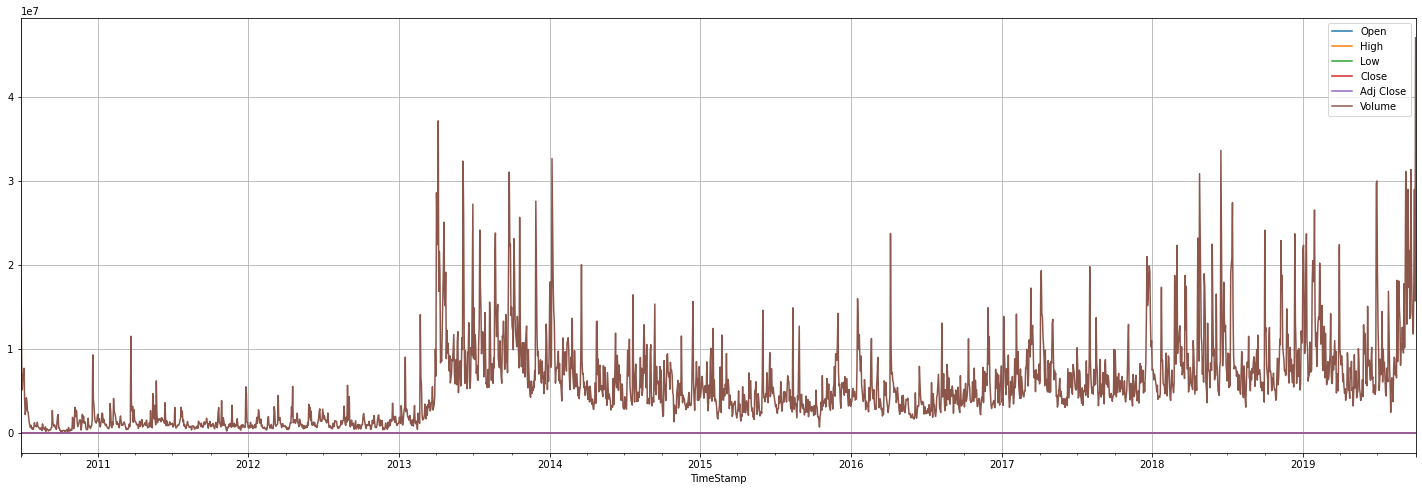

In [20]:
from pylab import rcParams 

rcParams['figure.figsize'] = 25,8
df_model.plot(grid=True);

## Dropping Unmwanted Columns

In [21]:
df_model = df_model.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'],axis=1)

In [22]:
df_model.head()

,Close
TimeStamp,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-05,16.110001


<AxesSubplot:xlabel='TimeStamp'>

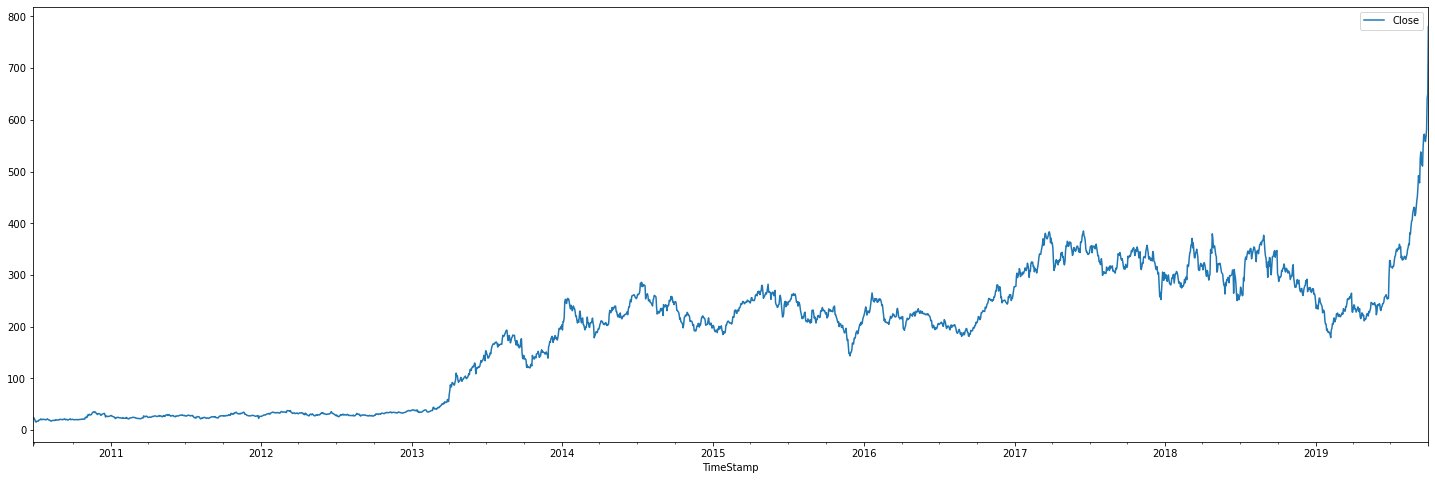

In [23]:
df_model.plot()

## Checking for Null values

In [25]:
df_model.isna().value_counts()

Close
False    2416
dtype: int64

In [26]:
df_model.isnull().sum()

Close    0
dtype: int64

<AxesSubplot:xlabel='TimeStamp'>

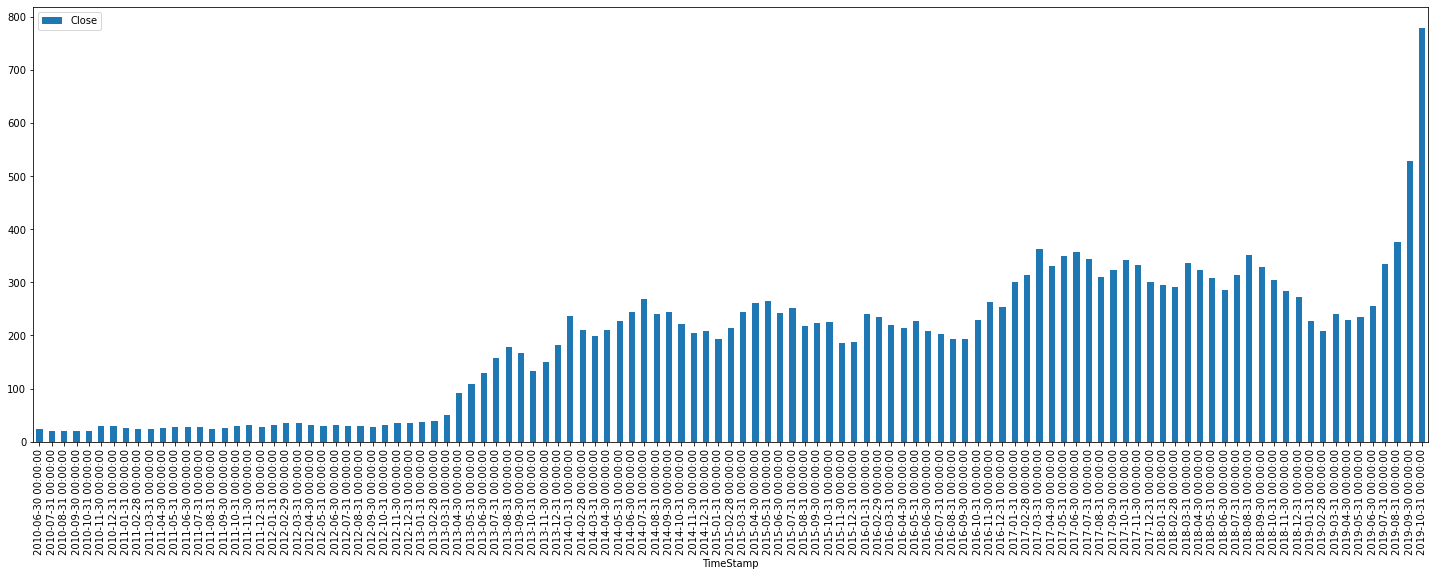

In [27]:
monthly_mean = df_model.resample('M').mean()
monthly_mean.plot.bar()

In [28]:
observations= df_model.values
test_result = adfuller(observations)

In [29]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: 1.400069
p-value: 0.997114
Critical Values:
	1%: -3.43308
	5%: -2.86275
	10%: -2.56741
